In [1]:
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import ruptures as rpt
import numpy as np
from pathlib import Path
from tqdm.notebook import tqdm
from typing import List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.io import wavfile
from python_speech_features import mfcc
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split

from scipy.stats import ttest_ind

In [2]:
def get_cpts(col: pd.Series) -> List[int]:
    signal = np.array(col)
    algo = rpt.Pelt(model="rbf").fit(signal)
    result = algo.predict(pen=len(signal) / 4)
    
    return result

def get_tl(col_f1: pd.Series, col_f2: pd.Series) -> float:
    start = int(len(col_f1) / 5)
    end = len(col_f1) - start
    return abs(
        col_f1.iloc[start,] - col_f1.iloc[end,]
    ) + abs(
        col_f2.iloc[start,] - col_f2.iloc[end,]
    )

In [3]:
def mfcc_cpts(folder: Path, mono: List[str], numcep: int,
              nfft: int, n_delim: int) -> Tuple[np.array, List[int]]:
    
    X = np.empty((0, numcep * 2 + 3))
    y = []

    for wav, csv in zip(Path(f'divided/{folder}/sounds/').iterdir(),
                        Path(f'divided/{folder}/csvs/').iterdir()):
        rate, signal = wavfile.read(wav)

        mfcc_feat = mfcc(signal, rate, numcep=numcep, nfft=nfft)
        scaler = MinMaxScaler()
        mfcc_feat = scaler.fit_transform(mfcc_feat.T).T

        mfcc_mean = np.mean(mfcc_feat, axis=0)
        mfcc_std = np.std(mfcc_feat, axis=0)


        df = pd.read_csv(csv)
        f1 = get_cpts(df['f1'])
        f2 = get_cpts(df['f2'])
        tl = get_tl(df.f1, df.f2)


        feat_vec = np.concatenate((mfcc_mean, mfcc_std))
        feat_vec = np.append(feat_vec, len(f1))
        feat_vec = np.append(feat_vec, len(f2))
        feat_vec = np.append(feat_vec, tl)

        X = np.vstack((X, feat_vec))

        # append the label (0 or 1) to y
        if csv.name.rsplit('_', n_delim)[1] in mono:
            y.append(0)
        else:
            y.append(1)
    
    return X, y

In [4]:
def draw_statistics(y: np.array, y_predicted: np.array) -> None:
    print(metrics.balanced_accuracy_score(y, y_predicted))

    sns.heatmap(np.flip(metrics.confusion_matrix(y, y_predicted)).T,
                annot=True, fmt='.0f',
                xticklabels = ['diphthong', 'monophthong'],
                yticklabels = ['diphthong', 'monophthong']
               )

    plt.xlabel('Real')
    plt.ylabel('Predicted');

In [16]:
def LogReg_results(X: np.array, y: List[int]) -> None:
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=666)

    cls = LogisticRegression()
    cls = cls.fit(X_train, y_train)
    y_predicted = cls.predict(X_test)

    draw_statistics(y_test, y_predicted)

In [6]:
numcep = 13

In [ ]:
est_mono = ['i', 'iː', 'iːː', 'æ', 'æː', 'æːː']

X_est_liisa, y_est_liisa = mfcc_cpts('est_liisa', est_mono, numcep, 1103, 3)

0.8928571428571428


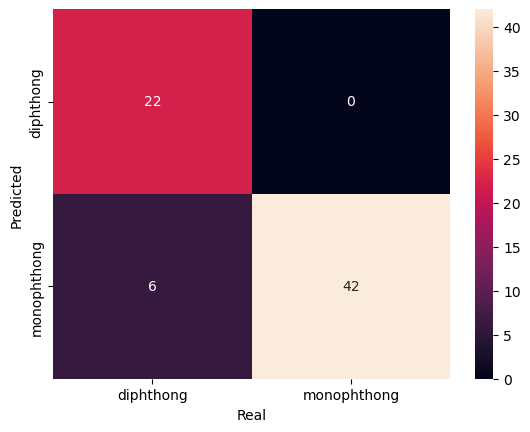

In [8]:
LogReg_results(X_est_liisa, y_est_liisa)

In [9]:
cls = LogisticRegression()
cls = cls.fit(X_est_liisa, y_est_liisa)

In [10]:
X_est_vello, y_est_vello = mfcc_cpts('est_vello', est_mono, numcep, 1103, 3)

0.7865659777424483


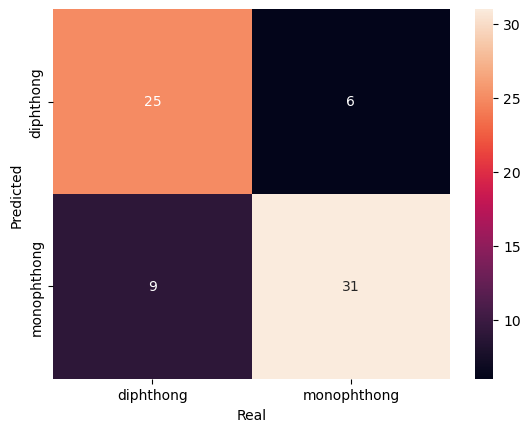

In [11]:
LogReg_results(X_est_vello, y_est_vello)

In [12]:
# cls = cls.fit(X, y)

## Lithuanian

In [13]:
lit_mono = ['ˈɛː', 'ˈi', 'ˈiː', 'iː', 'i', 'ɛː', 'ˈeː', 'ɛ', 'eː']

X_lit, y_lit = mfcc_cpts('lit', lit_mono, numcep, 1103, 3)

0.9071542694834014


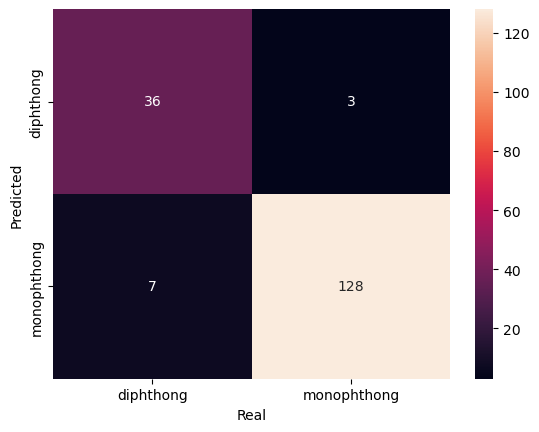

In [14]:
LogReg_results(X_lit, y_lit)

In [15]:
# cls = cls.fit(X, y)

## Skolt Saami

In [16]:
skolt_mono = ['e', 'eː', 'õ', 'õː', 'â', 'âː', 'i', 'iː']

X_skolt, y_skolt = mfcc_cpts('skolt', skolt_mono, numcep, 1103, 4)

In [17]:
y_predicted = cls.predict(X_skolt)

print(metrics.confusion_matrix(y_skolt, y_predicted))
print(metrics.f1_score(y_skolt, y_predicted))

[[67 15]
 [11 36]]
0.7346938775510204


0.9230769230769231


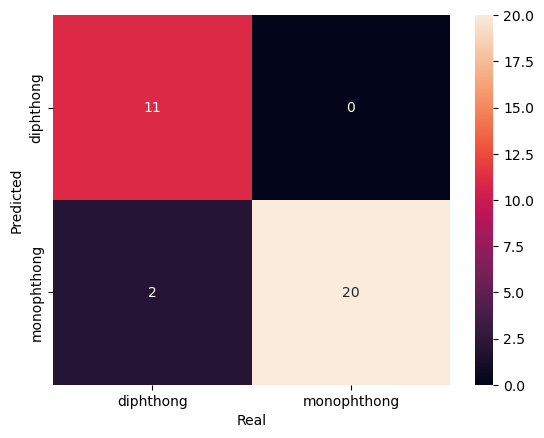

In [18]:
LogReg_results(X_skolt, y_skolt)

## Kildin Saami

In [19]:
kld_mono = ['e', 'iː', 'aː', 'eː']

X_kildin, y_kildin = mfcc_cpts('kld', kld_mono, numcep, 1103, 3)

In [20]:
y_predicted = cls.predict(X_kildin)

print(metrics.confusion_matrix(y_kildin, y_predicted))
print(metrics.f1_score(y_kildin, y_predicted))

[[120  29]
 [ 62  58]]
0.5603864734299516


0.8376623376623377


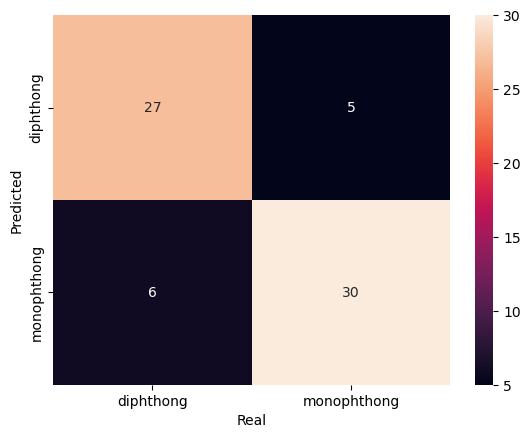

In [21]:
LogReg_results(X_kildin, y_kildin)

## Russian

In [19]:
rus_mono = ['e', 'ɨ', 'a', 'o', 'u', 'ji']

X_rus, y_rus = mfcc_cpts('rus', rus_mono, numcep, 1103, 3)

0.9


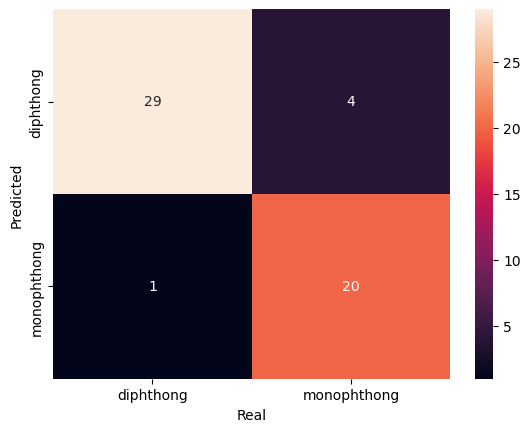

In [20]:
LogReg_results(X_rus, y_rus)

In [11]:
cls = LogisticRegression()
cls = cls.fit(X_rus, y_rus)

y_predicted = cls.predict(X_rus)

print(metrics.confusion_matrix(y_rus, y_predicted))
print(metrics.f1_score(y_rus, y_predicted))

[[ 87   0]
 [  0 129]]
1.0


## Model

In [ ]:
X_new = np.vstack((X_est_liisa, X_lit))
y_new = y_est_liisa + y_lit

0.7518162947586922


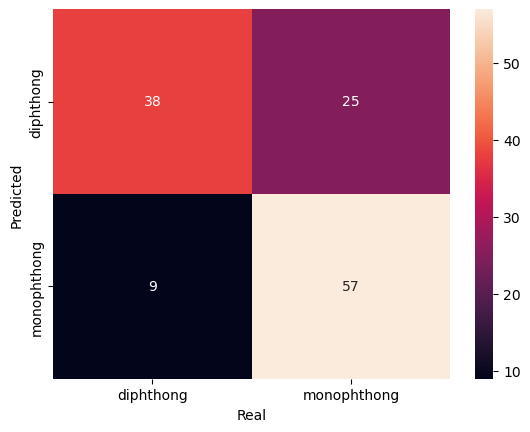

In [23]:
cls = LogisticRegression()
cls = cls.fit(X_new, y_new)

y_predicted = cls.predict(X_skolt)
draw_statistics(y_skolt, y_predicted)

0.6477069351230426


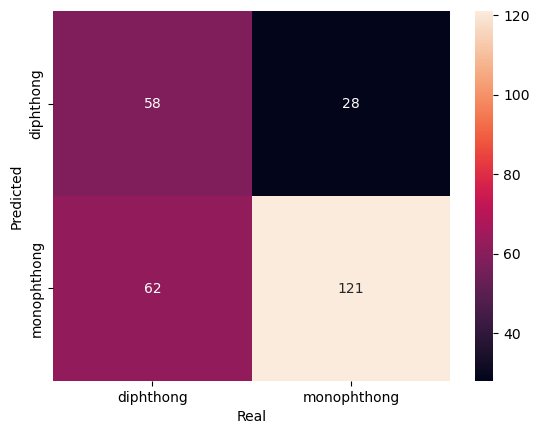

In [24]:
cls = LogisticRegression()
cls = cls.fit(X_new, y_new)

y_predicted = cls.predict(X_kildin)

draw_statistics(y_kildin, y_predicted)